In [ ]:
# default_exp model.learner

In [ ]:
from IPython.core.debugger import set_trace
from IPython.utils import traitlets as _traitlets

/tmp/ipykernel_1330094/2943078347.py:2: UserWarning: IPython.utils.traitlets has moved to a top-level traitlets package.
  from IPython.utils import traitlets as _traitlets


<h1><center> Learner </center></h1>

In this module, we define the model architecture that we will use in our learner. It will be based on [`tsai`](https://github.com/timeseriesAI/tsai) models with a simple tweak: ability to handle categorical features.

The strategy to build our model is fairly simple:
+ apply a specific 'Embedding` layer to each categorical feature
+ concatenate the outcome of the embedding layers with the continuous features
+ pass the resulting tensor to a `tsai` existing model
The first 2 steps can be handled by the *head* of the network which can be seen as a layer.

Once the architecture defined, we can define our learner in the usual way and benefit from `fastai` training loop.

In [ ]:
# export
import glob
import os
import pickle
import tempfile
import warnings
from random import sample
from typing import List, Tuple
from pathlib import Path

import numpy as np
import pandas as pd
from fastai.layers import trunc_normal_
from fastai.tabular.all import *
from fastai.text.all import *
from fastai.vision.all import *
from fastcore.basics import *
from fastcore.xtras import load_pickle, save_pickle
from progressbar import progressbar
from tsai.all import *

from footSeq.datastruct.core import *

In [ ]:
data_path = Path("/sequences_new")
metadata_path = Path("./data")
files_list_path = metadata_path / "file_list.pkl"
if os.path.isfile(files_list_path):
    all_files = load_pickle(files_list_path)
else:
    all_files = data_path.ls(file_exts=".csv")

In [ ]:
##all_files = all_files[:100000]

In [ ]:
no_goal_prop = 2
valid_pct = 0.3
seed = 44

In [ ]:
train_goals, test_goals, no_goals = pick_files(all_files)
n_no_goals_train = int(train_goals.shape[0] * no_goal_prop)
files_info = pd.concat([train_goals, no_goals.sample(n_no_goals_train)], axis=0).sample(
    frac=1, ignore_index=True
)

## test files
n_no_goals_test = int(test_goals.shape[0] * no_goal_prop)
no_goals_left = no_goals[~no_goals.file.isin(files_info.file)].sample(n_no_goals_test)
test_files_info = pd.concat([test_goals, no_goals_left], axis=0).sample(
    frac=1, ignore_index=True
)

labels = L(files_info.target.tolist()).unique(sort=True)
files_info

100% (4409477 of 4409477) |##############| Elapsed Time: 0:22:43 Time:  0:22:43


,id,gameId,possNumber,startId,endId,target,file,nSteps
0,1171280_10627-10630,1171280,45,10627,10630,no-goal,/sequences_new/1171280___45___10627___10630___no-goal.csv,4
1,1098544_20544-20547,1098544,166,20544,20547,goal,/sequences_new/1098544___166___20544___20547___goal.csv,3
2,1098540_11467-11486,1098540,166,11467,11486,no-goal,/sequences_new/1098540___166___11467___11486___no-goal.csv,19
3,1171333_15848-15859,1171333,200,15848,15859,no-goal,/sequences_new/1171333___200___15848___15859___no-goal.csv,12
4,1171654_40994-40998,1171654,242,40994,40998,no-goal,/sequences_new/1171654___242___40994___40998___no-goal.csv,4
...,...,...,...,...,...,...,...,...
200650,1171798_11880-11882,1171798,155,11880,11882,no-goal,/sequences_new/1171798___155___11880___11882___no-goal.csv,3
200651,1207268_51052-51062,1207268,201,51052,51062,no-goal,/sequences_new/1207268___201___51052___51062___no-goal.csv,9
200652,1171399_75207-75213,1171399,56,75207,75213,no-goal,/sequences_new/1171399___56___75207___75213___no-goal.csv,7
200653,1171488_5792-5808,1171488,66,5792,5808,goal,/sequences_new/1171488___66___5792___5808___goal.csv,17


In order to test our different examples, let's prepare a batch of data:

In [ ]:
cat_names = [
    "standart_name",
    "possession_name",
    "attack_status_name",
    "attack_type_name",
    "under_pressure",
    "high_speed",
    "type_name",
    "result_name",
    "generic_action_type_name",
    "body_name",
    "is_poss_team",
    "is_att_team",
]
cont_names = [
    "start_x",
    "start_y",
    "end_x",
    "end_y",
    "time_seconds",
    "seconds_since_poss",
]

files = L(files_info.file.tolist())


## splits
splits_files = goal_splitter(
    files_info_df=files_info, no_goal_prop=no_goal_prop, valid_pct=valid_pct, seed=seed
)

procs = [FillMissing, Categorify, Normalize]
foot_tfm = FootSeqTransform(
    files=files,
    splits=splits_files,
    labels=labels,
    procs=procs,
    cat_names=cat_names,
    cont_names=cont_names,
)


## to-tensor transform
to_tsr = FootSeqToTensor(
    cat_names=cat_names,
    cont_names=cont_names,
    labels=labels,
    base_path=data_path,
    max_len=10,
)

## tfmdlist
tls = TfmdLists(files, [foot_tfm, to_tsr], splits=splits_files)

## params for datalodaers
train_seq_lens = L(min(get_sequence_len(file), 10) for file in files[splits_files[0]])
valid_seq_lens = L(min(get_sequence_len(file), 10) for file in files[splits_files[1]])


## pass the training dataset sequence lengths to SortedDL
srtd_dl = partial(SortedDL, res=train_seq_lens)

## Pass the validation dataset seq lengths
dl_kwargs = [{}, {"val_res": valid_seq_lens}]

## re-initialise dataloaders
srtd_dls = tls.dataloaders(
    bs=3, before_batch=pad_seq, dl_type=srtd_dl, dl_kwargs=dl_kwargs
)
srtd_batch = srtd_dls.one_batch()

srtd_batch

100% (140459 of 140459) |################| Elapsed Time: 0:15:10 Time:  0:15:10


(tensor([[1214346,     232,   95284,   95293],
         [1171072,      61,    5882,    5891],
         [1233051,     183,   35834,   35844]]),
 tensor([[[ 5,  1,  4,  5,  1,  1,  5,  3, 12,  6,  2,  2],
          [ 5,  1,  1,  5,  1,  1,  9,  3,  3,  6,  2,  2],
          [ 5,  1,  1,  5,  1,  1, 26,  3, 12,  6,  2,  2],
          [ 5,  1,  1,  5,  1,  1,  9,  3,  3,  6,  2,  2],
          [ 5,  1,  1,  5,  1,  1, 26,  3, 12,  6,  2,  2],
          [ 5,  1,  1,  5,  1,  1,  9,  3,  3,  6,  2,  2],
          [ 5,  1,  1,  5,  1,  1,  6,  1, 12,  6,  2,  2],
          [ 5,  1,  1,  5,  1,  1, 32,  3, 11,  6,  1,  1],
          [ 5,  1,  2,  5,  1,  1,  6,  1, 12,  6,  1,  1],
          [ 5,  1,  4,  5,  1,  1, 17,  3,  8,  6,  2,  2]],
 
         [[ 5,  1,  4,  5,  1,  1,  5,  3, 12,  2,  2,  2],
          [ 5,  1,  1,  5,  1,  1,  9,  3,  3,  6,  2,  2],
          [ 5,  1,  1,  5,  1,  1,  5,  3, 12,  6,  2,  2],
          [ 5,  1,  1,  5,  1,  1, 34,  3, 13,  6,  2,  2],
          [ 5,

# Model

## Embedding

In [ ]:
# export


@delegates()
class Embedding(nn.Embedding):
    """
    Embedding layer compatible with full pytorch API and truncated normal initialization

    Parameters
    ----------
    ni, nf: int
        input and output size of Embedding layer. It is the same
        as `num_embeddings` and `embedding_dim` in `torch.nn.Embedding()` module
    kwargs: dict
        Any argument accepted by `torch.nn.Embedding()` module
        a part from `num_embeddings` and `embedding_dim`
    std: float
        standard deviation applied in the truncated normal

    """

    def __init__(self, ni, nf, std=0.01, **kwargs):
        kwargs["num_embeddings"], kwargs["embedding_dim"] = ni, nf
        super().__init__(**kwargs)
        trunc_normal_(self.weight.data, std=std)


class MultiEmbedding(Module):
    """
    Muti-dimesnion Embedding layer

    Attributes
    ----------
    cat_embed: torch.nn.ModuleList
        list of Embedding modules in the order in which categorical data appear

    """

    def __init__(
        self,
        n_embeds: List[int],
        embed_dims: List[int] = None,
        embed_p: float = 0.0,
        n_cont: int = 0,
        std: float = 0.01,
        **kwargs
    ):
        """
        Initialise the various embedding sizes

        Parameters
        ----------
        n_embdes: List[int]
            length of the vocabulary of each categorical feature in the same order as passed in the tensor

        embed_dims: List[int]
            required size of each categorical feature embedding in the same order as passed in the tensor

        embed_p: float
            if non zero, applies a dropout layer to the the categorical features after embedding.

        n_cont: int, optional
            number of continuous features

        std: float
            standard deviation applied in the truncated normal
        kwargs: dict
            extra parameters passed to the embedding layer. Should be
            compatible with `torch.nn.Embedding()`

        """
        assert n_cont >= 0, "number of continuous features should be positive"
        self.n_cont = n_cont
        ## verify embedding size
        if embed_dims is None:
            embed_dims = [emb_sz_rule(s) for s in n_embeds]
        else:
            embed_dims = listify(embed_dims)
            if len(embed_dims) == 1:
                embed_dims = embed_dims * len(n_embeds)
            assert len(embed_dims) == len(n_embeds)

        self.emb_drop = nn.Dropout(embed_p)
        self.cat_embed = nn.ModuleList(
            [
                Embedding(ni=n, nf=d, std=std, **kwargs)
                for n, d in zip(n_embeds, embed_dims)
            ]
        )

    def forward(self, x_cat, x_cont=None):
        if isinstance(x_cat, tuple): 
            if len(x_cat) == 2:
                x_cat, x_cont = x_cat
            elif len(x_cat) == 3:
                _, x_cat, x_cont = x_cat
            else:
                raise ValueError("x_cat is a tuple of unknown size")
            
            
        x_cat = torch.cat([e(x_cat[..., i]) for i, e in enumerate(self.cat_embed)], -1)
        x_cat = self.emb_drop(x_cat)
        if self.n_cont != 0:
            x_cat = torch.cat([x_cat, x_cont], -1)
        return x_cat

In order to test this layer, we need to find the vocabulary size of each categorical variable and pass it in `n_embeds`:

In [ ]:
n_embeds = [len(tls.to.classes[n]) for n in tls.to.cat_names]
(tls.to.cat_names, n_embeds)

((#12) ['standart_name','possession_name','attack_status_name','attack_type_name','under_pressure','high_speed','type_name','result_name','generic_action_type_name','body_name'...],
 [8, 6, 5, 8, 3, 3, 51, 4, 15, 7, 3, 3])

Now let's initialize the layer and check that it works as expected:

In [ ]:
n_cont = srtd_batch[2].shape[-1]
multi_em = MultiEmbedding(n_embeds=n_embeds, n_cont=n_cont)
tsr_em = multi_em(srtd_batch[1], srtd_batch[2])
test_eq(
    tsr_em.shape[-1],
    L(w.weight.shape[-1] for w in multi_em.cat_embed).sum() + n_cont,
)

Now let's investigate how we can use the `padding_idx` option. This can be very useful to avoid training useless weight corresponding to padding values. Let's first create a batch with some padded values:

In [ ]:
reg_dls = tls.dataloaders(bs=5, before_batch=pad_seq)
padded_batch = reg_dls.one_batch()
padded_batch[1][1]

tensor([[ 5,  1,  4,  1,  1,  1,  5,  3, 12,  6,  2,  2],
        [ 5,  1,  1,  1,  1,  1, 10,  3,  4,  6,  2,  2],
        [ 5,  1,  1,  1,  1,  1, 34,  3, 13,  6,  2,  2],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0]])

In [ ]:
multi_em_pad = MultiEmbedding(n_embeds, padding_idx=0, n_cont=n_cont)
tsr_em = multi_em_pad(padded_batch[1], padded_batch[2])
tsr_em[0]

tensor([[-1.5237e-02, -4.1248e-03, -1.3151e-02, -9.6135e-03, -2.7968e-03,
          1.3238e-02,  4.8911e-03, -3.8251e-03,  3.2412e-03, -1.8227e-02,
          1.5564e-03,  3.3955e-03,  1.2075e-02,  8.9293e-04,  7.8788e-03,
         -1.1770e-02,  1.9000e-02, -4.8020e-03, -3.8520e-03,  9.9133e-03,
          1.9030e-02,  1.0817e-02, -9.1170e-03, -1.2074e-02, -4.8188e-03,
         -2.1974e-03,  1.0516e-02, -4.6146e-03,  1.5063e-03, -1.7044e-02,
         -7.3083e-03, -1.1137e-02,  9.4846e-03, -5.7074e-03, -2.3631e-03,
         -1.3099e-02, -2.2664e-03, -1.5038e-02, -1.8442e-02,  9.6811e-03,
         -2.7491e-03,  8.2854e-03, -8.1784e-03,  8.9634e-03,  2.0411e-03,
         -1.3586e-03, -1.2347e-02, -6.1733e-04, -4.5991e-03, -7.6719e-03,
         -1.1809e-03,  7.9909e-03, -1.8805e-02, -5.0546e-03,  1.6516e-02,
          1.3184e-02, -1.2109e-03,  7.5670e-03,  1.0764e-02, -6.0312e-01,
         -5.5363e-01,  2.7876e-01, -1.2855e+00, -2.8368e-01, -7.9208e-01],
        [-1.5237e-02, -4.1248e-03, -1

Notice how the dimension with all zeros (the default padding index) are also filled in with all zeros in the resulting tensor.

## Full Architecture

Now we are ready to plug in the embedding to any `tsai` learner. Our architecture is fairly straightforward:
+ `head` is the head of the network and runs the data through the `multiEmbedding` layer
+ `body` takes the output of `head` and run it through the desired architecture selected by the user in `ts_arch`

In [ ]:
# export


@delegates(build_ts_model)
class MixedSeqModel(Module):
    "Sequence model with an embedding head."

    def __init__(
        self,
        arch: Module,
        n_cont: int,
        c_out: int,
        embded_config: dict = None,
        **kwargs
    ):
        """
        Intialise the model architecture

        Parameters
        ----------
        arch: Module
            one of tsai Model architectures accepted by `build_ts_model()`
        c_out: int
            number of output layers
        n_cont: int
            number of continuous features
        embed_config: dict
            all parameters accepted by the `MultiEmbedding` layer
        kwargs:
            Extra parameters accepted by `build_ts_model()`

        """
        ## head of the network
        embded_config["n_cont"] = n_cont
        self.head = MultiEmbedding(**embded_config)

        ## inialise the body
        self.arch, self.c_out, self.n_cont = arch, c_out, n_cont
        self.c_in = L(w.weight.shape[-1] for w in self.head.cat_embed).sum() + n_cont
        kwargs["arch"], kwargs["c_in"], kwargs["c_out"] = (
            self.arch,
            self.c_in,
            self.c_out,
        )

        self.body = build_ts_model(**kwargs)

    def forward(self, x_meta, x_cat, x_cont):
        if isinstance(x_meta, tuple): 
            if len(x_meta) == 2:
                x_cat, x_cont = x_meta
            elif len(x_meta) == 3:
                _, x_cat, x_cont = x_meta
            else:
                raise ValueError("x_meta is a tuple of unknown size")
        x = self.head(x_cat, x_cont)

        return self.body(x.transpose(2, 1))

In [ ]:
from tsai.models.RNN_FCN import *

n_cont = padded_batch[2].shape[-1]

## select the architecture
ts_model = LSTM_FCN
ts_args = {"bidirectional": True, "rnn_layers": 2, "shuffle": False}

## LSTM
##ts_model = LSTM
##ts_args = {"n_layers":2, "bidirectional":True}

model = MixedSeqModel(
    arch=ts_model,
    n_cont=n_cont,
    c_out=2,
    embded_config={"n_embeds": n_embeds, "embed_p": 0.1},
    **ts_args
)
model

MixedSeqModel(
  (head): MultiEmbedding(
    (emb_drop): Dropout(p=0.1, inplace=False)
    (cat_embed): ModuleList(
      (0): Embedding(8, 5)
      (1): Embedding(6, 4)
      (2): Embedding(5, 4)
      (3): Embedding(8, 5)
      (4): Embedding(3, 3)
      (5): Embedding(3, 3)
      (6): Embedding(51, 14)
      (7): Embedding(4, 3)
      (8): Embedding(15, 7)
      (9): Embedding(7, 5)
      (10): Embedding(3, 3)
      (11): Embedding(3, 3)
    )
  )
  (body): LSTM_FCN(
    (rnn): LSTM(65, 100, num_layers=2, batch_first=True, bidirectional=True)
    (rnn_dropout): Dropout(p=0.8, inplace=False)
    (shuffle): Permute(dims=0, 2, 1)
    (convblock1): ConvBlock(
      (0): Conv1d(65, 128, kernel_size=(7,), stride=(1,), padding=(3,), bias=False)
      (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (convblock2): ConvBlock(
      (0): Conv1d(128, 256, kernel_size=(5,), stride=(1,), padding=(2,), bias=False)
      (1): BatchNor

In [ ]:
model(padded_batch[0], padded_batch[1], padded_batch[2])

TensorBase([[-0.1012,  0.0648],
        [-0.0755,  0.0294],
        [-0.2318, -0.1329],
        [-0.3229, -0.0324],
        [-0.2271, -0.0887]], grad_fn=<AliasBackward0>)

# Learner

Defining a learner at this stage is straightforward, we just need to decide on the appropriate loss function to use, pass the `dataloaders` and the metrics we want to track. Moreover, the `tsai` `ts_learner` function provides a great interface that we could extend to meet our purposes: 

## Specific class for the `Learner`
We define a specific class `MixedSeqLearner` that knows how to predict the sequence and how to show results:

In [ ]:
# export


class MixedSeqLearner(Learner):
    "`Learner` for mixed sequence data"

    def predict(self, files: List[Path]):
        "Predict a sequence of play read from a file"
        with self.no_bar():
            dl = self.dls.test_dl(listify(files))
            preds, _, cls_preds = self.get_preds(dl=dl, with_decoded=True)
            labels = dl.tfms.target_vocab[0]
            probs = pd.DataFrame(preds.detach().numpy(), columns=labels)
            clss = [labels[i] for i in cls_preds]

        return probs, clss


@delegates(build_ts_model)
def mixed_seq_learner(
    arch: Module,
    n_cont: int,
    c_out: int,
    embded_config: dict = None,
    # learner args
    dls=None,
    splitter=trainable_params,
    loss_func=None,
    opt_func=Adam,
    lr=defaults.lr,
    cbs=None,
    metrics=None,
    path=None,
    model_dir="models",
    wd=None,
    wd_bn_bias=False,
    train_bn=True,
    moms=(0.95, 0.85, 0.95),
    # other model args
    **kwargs
):
    """
    Interface to create a `Learner` for sequences with continuous and categorical features

    Parameters
    ----------
    arch: Module
        one of tsai Model architectures accepted by `build_ts_model()`
    c_out: int
        number of output layers
    n_cont: int
        number of continuous features
    embed_config: dict
        all parameters accepted by the `MultiEmbedding` layer

    Returns
    -------
    fastai.Learner
        Learner object with the `MixedSeqModel` model architecture

    """
    if arch is None:
        arch = LSTM

    model = MixedSeqModel(
        arch=arch, n_cont=n_cont, c_out=c_out, embded_config=embded_config, **kwargs
    )
    try:
        model.body[0], model.body[1]
        subscriptable = True
    except:
        subscriptable = False
    if subscriptable:
        splitter = ts_splitter
    if loss_func is None:
        if hasattr(dls, "loss_func"):
            loss_func = dls.loss_func
        elif hasattr(dls, "train_ds") and hasattr(dls.train_ds, "loss_func"):
            loss_func = dls.train_ds.loss_func
        elif hasattr(dls, "cat") and not dls.cat:
            loss_func = MSELossFlat()

    learn = MixedSeqLearner(
        dls=dls,
        model=model,
        loss_func=loss_func,
        opt_func=opt_func,
        lr=lr,
        cbs=cbs,
        metrics=metrics,
        path=path,
        splitter=splitter,
        model_dir=model_dir,
        wd=wd,
        wd_bn_bias=wd_bn_bias,
        train_bn=train_bn,
        moms=moms,
    )

    # keep track of args for loggers
    store_attr("arch", self=learn)

    return learn

## Useful Learner methods

### Predict the full possession

We are particularly interested in predicting how the probability of scoring changes as the sequence progresses: In order to do that, we need to sort the sequences in acending order and produce the probabilities progressively: 

In [ ]:
#export

@patch
def predict_poss(self: MixedSeqLearner, seq_df: pd.DataFrame, verbose: bool = False) -> pd.DataFrame:
    "Predict possession outcome probability in a sequentiel way"

    time_seconds = L(seq_df["time_seconds"].sort_values().tolist()).unique()

    def _get_probs(time):
        _df = seq_df[seq_df["time_seconds"] <= time]
        _dir = tempfile.TemporaryDirectory()
        _file = _df._id.values[0] + ".csv"
        
        file_name = Path(_dir.name) / _file
        res = None
        _df.to_csv(file_name)
        with self.no_bar():
            _proba = self.predict([Path(file_name)])[0]
        res = pd.DataFrame(
            {
                "time_seconds": time,
                "proba_goal": _proba["goal"],
                "proba_no-goal": 1.0 - _proba["goal"],
            },
            index=[0],
        )

        return res
    
    if verbose:
        _time_probs = [_get_probs(_time) for _time in progressbar(time_seconds)]
    else:
        _time_probs = [_get_probs(_time) for _time in time_seconds]
    time_probs = (
            pd.concat(_time_probs, axis=0)
            .sort_values(["time_seconds"])
            .reset_index(drop=True)
        )
    
    
    return seq_df.merge(time_probs, on="time_seconds", how="left")

#### Predict an entire game

The next step is to be able to predict an entire game. The strategy is the following:
+ extract the data from the database
+ predict the possessions one by one
+ concatenate the data by row

In [ ]:
#export

def predict_game(learn: MixedSeqLearner, game_id: int, verbose: bool = False) -> pd.DataFrame:
    "Predict (all the possessions in) a game"
    pass

## Define and Train a learner

Let's define a learner now with the `LSTM_FCN` architecture and find an appropriate learning rate:

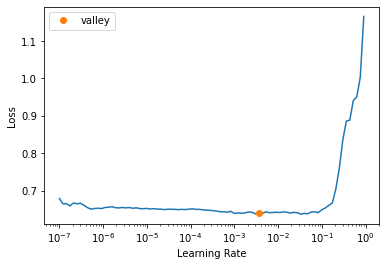

In [ ]:
from fastai.metrics import *

n_cont = padded_batch[2].shape[-1]

## prepare dataloaders
srtd_dls = tls.dataloaders(
    bs=64, before_batch=pad_seq, dl_type=srtd_dl, dl_kwargs=dl_kwargs
)

## select the architecture
ts_model = LSTM_FCN
ts_args = {"bidirectional": True, "rnn_layers": 2, "shuffle": False}
model_name = "_".join(
    [
        ts_model.__name__,
        f'bidir-{ts_args.get("bidirectional",False)}',
        f'layers-{ts_args.get("rnn_layers", 1)}',
        f"no_goal_prop-{no_goal_prop}",
    ]
)

## create directory if it does not exist
if not os.path.exists(Path("./models") / model_name): os.makedirs(Path("./models") / model_name)

learn = mixed_seq_learner(
    arch=ts_model,
    n_cont=n_cont,
    c_out=2,
    embded_config={"n_embeds": n_embeds, "embed_p": 0.1},
    dls=srtd_dls,
    loss_func=CrossEntropyLossFlat(),
    metrics=[accuracy],
    path=Path("."),
    model_dir=Path("./models") / model_name,
    **ts_args,
)
lr_ = learn.lr_find()

We can train the learner for a number of cycles:

In [ ]:
n_cycles = 2
learn.fit_one_cycle(n_cycles, lr_max=lr_[0], cbs=SaveModelCallback(fname=model_name))

epoch,train_loss,valid_loss,accuracy,time
0,0.489356,0.474098,0.767044,59:39
1,0.470183,0.464988,0.769802,1:04:39


Better model found at epoch 0 with valid_loss value: 0.4740980565547943.
Better model found at epoch 1 with valid_loss value: 0.46498793363571167.


Finally, we save the best learner using the `save_all()` method:

In [ ]:
learn.save_all(
    path=Path("./models") / model_name,
    dls_fname="dls",
    model_fname="model",
    learner_fname="learner",
    verbose=True
)

Learner saved:
path          = 'models/LSTM_FCN_bidir-True_layers-2_no_goal_prop-2'
dls_fname     = '['dls_0.pth', 'dls_1.pth']'
model_fname   = 'model.pth'
learner_fname = 'learner.pkl'


## Predict Unseen Sequences

We can now compute some predictions on some files. We will select `n_ex` sequences ending with a goal and the same number ending in no-goal:

In [ ]:
n_ex = 3

test_files = (
    test_goals.sample(n_ex)["file"].to_list()
    + no_goals[~no_goals.file.isin(files_info.file)].sample(n_ex)["file"].to_list()
)

In [ ]:
learn.predict(test_files)

(       goal   no-goal
 0  0.330172  0.669828
 1  0.926472  0.073528
 2  0.999960  0.000040
 3  0.331437  0.668563
 4  0.230987  0.769013
 5  0.308765  0.691235,
 ['no-goal', 'goal', 'goal', 'no-goal', 'no-goal', 'no-goal'])

Looking at raw numbers is fine but it is better to visualize the actions on a pitch. In order to do that, we provide a proper `show_results()` method that knows how to display the sequence together with the predictions:

In [ ]:
#export

@typedispatch
def show_results(
    x: tuple,
    y,
    samples,
    outs,
    ctxs=None,
    max_n=6,
    nrows=None,
    ncols=1,
    figsize=None,
    **kwargs,
):
    n_elems = len(samples)
    if max_n > n_elems:
        max_n = n_elems
    if figsize is None:
        figsize = (10, 10 * 2.7)
    if ctxs is None:
        fig, ctxs = get_grid(
            max_n, nrows=None, ncols=ncols, figsize=figsize, return_fig=True
        )

    ## collect learner if available
    if "learner" in kwargs:
        learn = kwargs["learner"]
        labels = learn.dls.tfms.target_vocab[0]
        with learn.no_bar():
            probs, _, pred_cls = learn.get_preds(dl=[x], with_decoded=True)
        probs = pd.DataFrame(probs.detach().numpy(), columns=labels)
        for i, ctx in enumerate(ctxs):
            pred_class = labels[pred_cls[i].item()]
            proba = probs[pred_class].values[i]
            title = f"Actual: {samples[i][1]} \n Prediction: {pred_class} ({proba:.3f})"
            samples[i].show(ctx=ctx, fig=fig, title=title)
    else:
        for i, ctx in enumerate(ctxs):
            title = f'Actual: {samples[i][1]} \n Prediction: {["goal","no_goal"][y[i].item()]}'
            samples[i].show(ctx=ctx, fig=fig, title=title)

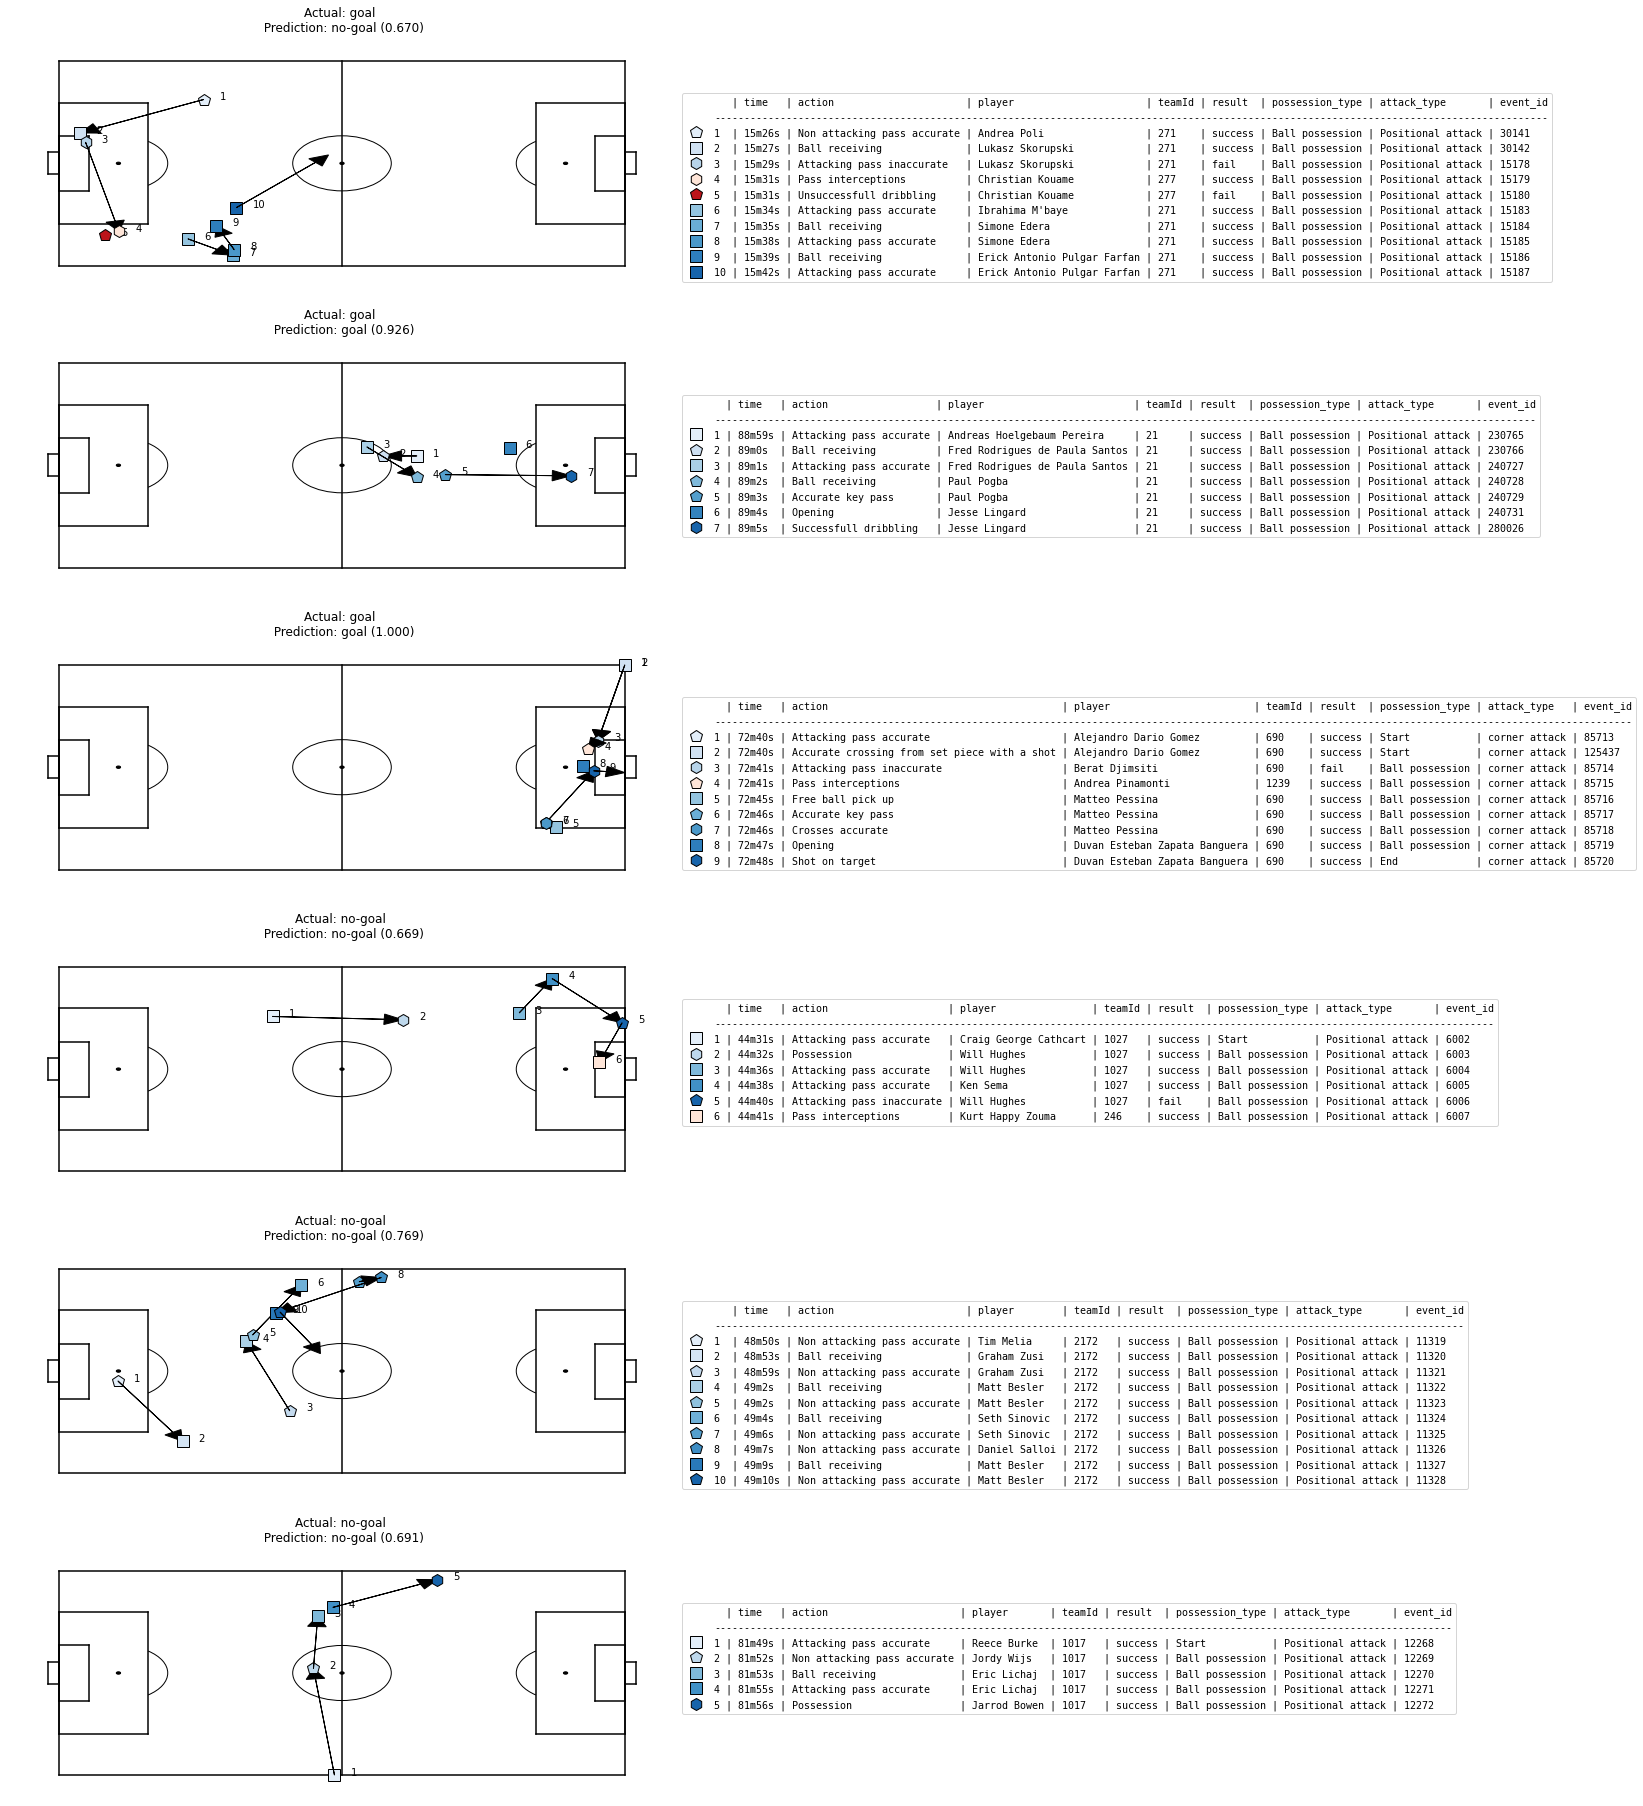

In [ ]:
base_fig_size = 12

test_dl = learn.dls.test_dl(test_files)
learn.show_results(
    dl=test_dl,
    figsize=(base_fig_size, base_fig_size * 2.7),
    max_n=6,
    ncols=1,
    learner=learn,
)

We can predict a full possession in the same way:

In [ ]:
goal_file_path = files_info[(files_info.target == "goal") & (files_info.nSteps == 5)].sample(1)["file"].values[0]
seq_df = pd.read_csv(goal_file_path)
x2 = learn.predict_poss(seq_df)
x2[
    [
        "type_name",
        "attack_type_name",
        "time_seconds",
        "player_name",
        "start_x",
        "start_y",
        "end_x",
        "end_y",
        "is_poss_team",
        "is_att_team",
        "proba_goal",
        "proba_no-goal",
    ]
]

,type_name,attack_type_name,time_seconds,player_name,start_x,start_y,end_x,end_y,is_poss_team,is_att_team,proba_goal,proba_no-goal
0,Attacking pass accurate,Positional attack,935.35,Matt Besler,24.8,38.7,37.3,42.6,True,True,0.244279,0.755721
1,Ball receiving,Positional attack,937.45,Yohan Croizet,37.3,42.6,37.3,42.6,True,True,0.245554,0.754446
2,Attacking pass accurate,Positional attack,939.33,Yohan Croizet,43.3,43.8,39.3,34.9,True,True,0.213086,0.786914
3,Attacking pass accurate,Positional attack,941.51,Ilie Sanchez Farres,39.3,34.9,61.2,23.5,True,True,0.261616,0.738384
4,Ball receiving,Positional attack,942.66,Roger Espinoza Ramirez,61.2,23.5,61.2,23.5,True,True,0.309915,0.690085


In [ ]:
x2.columns

Index(['event_id', 'player_id', 'player_name', 'team_id', 'team_name',
       'period_id', 'time_seconds', 'standart_name', 'possession_name',
       'possession_team_id', 'possession_number', 'attack_status_name',
       'attack_type_name', 'attack_team_id', 'under_pressure', 'high_speed',
       'action_id', 'type_name', 'result_id', 'generic_action_type_id',
       'generic_action_type_name', 'start_x', 'start_y', 'end_x', 'end_y',
       'body_name', 'gate_x', 'gate_y', 'result_name', 'seconds_since_poss',
       'is_poss_team', 'is_att_team', '_id', 'proba_goal', 'proba_no-goal'],
      dtype='object')

Finally, we provide a function to predict an entire game. The objective is to be 